In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_ts
from warnings import simplefilter
simplefilter("ignore")

In [2]:
df = get_ts(coin="nexo",days=500)
df.head(3)

,prices,market_caps,total_volumes
2020-06-14,0.114171,6.385255e+07,2.083129e+06
2020-06-15,0.111892,6.272421e+07,2.311847e+06
2020-06-16,0.111156,6.234541e+07,4.431391e+06


In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [4]:
# Testing "direct strategy" (1 step : 1 model) & multiple outputs

In [5]:
def make_lags(ts, lags:int, lead_time=1):
    """Creates Lag-Features"""
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four days of lag features
y = df.prices.copy()
X = make_lags(y, lags=4).fillna(0.0)

def make_multistep_target(ts, steps):
    """Creates step-ahead targets (multiple outouts)"""
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# n-days forecast
y = make_multistep_target(y, steps=5).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [7]:
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 0.14
Test RMSE: 0.16


The longer our forecast, the higher RMSE.

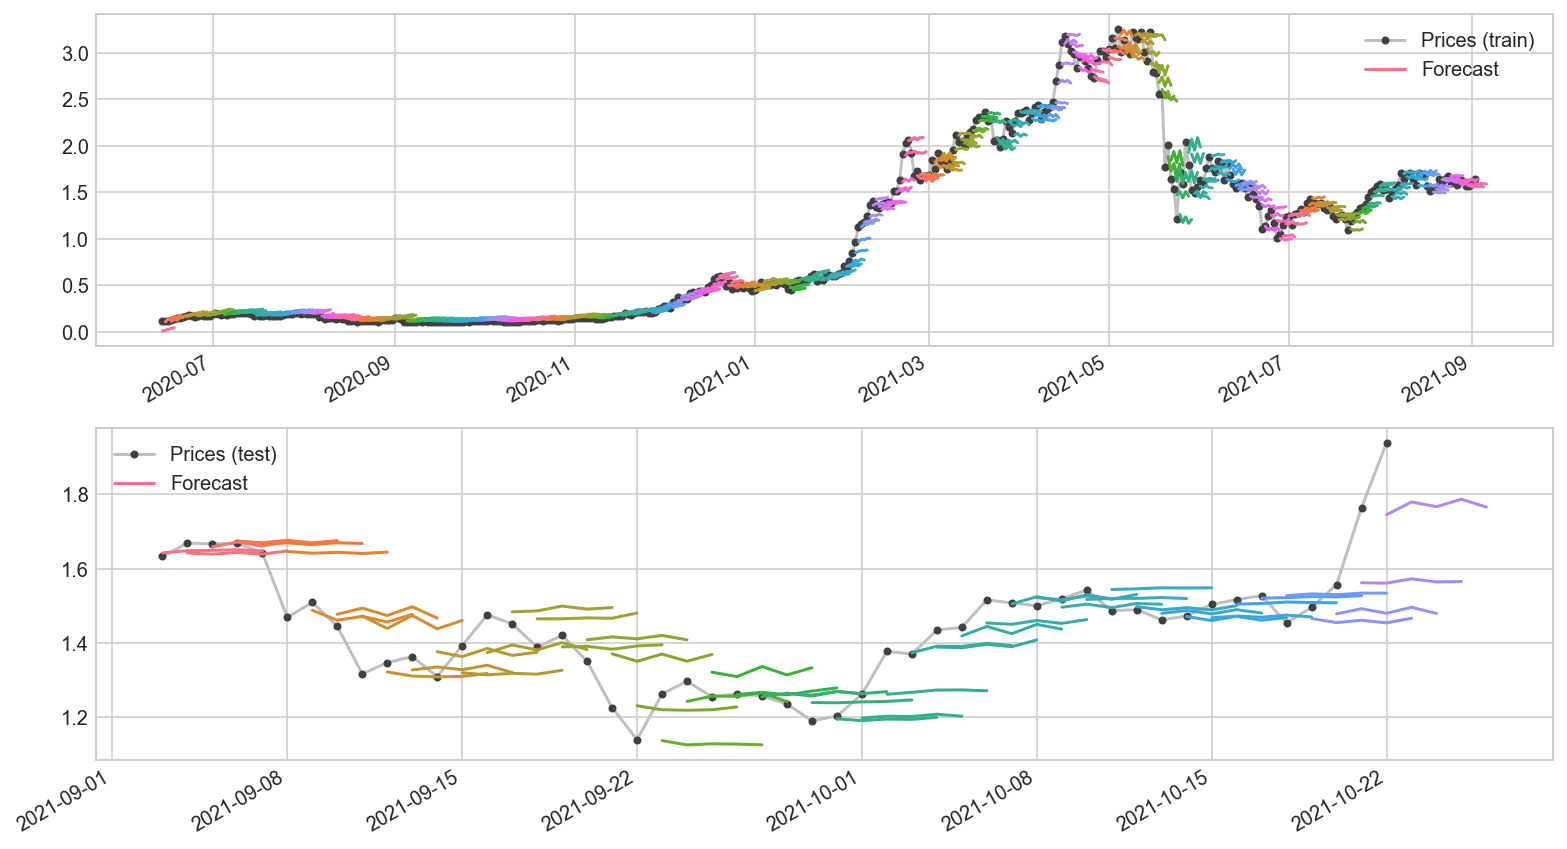

In [8]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = df.prices[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Prices (train)', 'Forecast'])

ax2 = df.prices[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Prices (test)', 'Forecast'])

In [9]:
todays_data = make_lags(df.prices.tail(),4).dropna()
predictions = model.predict(make_lags(df.prices.tail(),4).dropna()).squeeze()
dates = [i.date() for i in pd.date_range(start="2021-10-27",periods=10)]

print("Prices for the next days\n")
for t in zip(dates,predictions):
    print(t[0], round(t[1],2))

Prices for the next days

2021-10-27 2.37
2021-10-28 2.35
2021-10-29 2.38
2021-10-30 2.34
2021-10-31 2.39


In [13]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from xgboost import XGBRegressor

model = MultiOutputRegressor(XGBRegressor(n_jobs=1))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [11]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 0.00
Test RMSE: 0.18


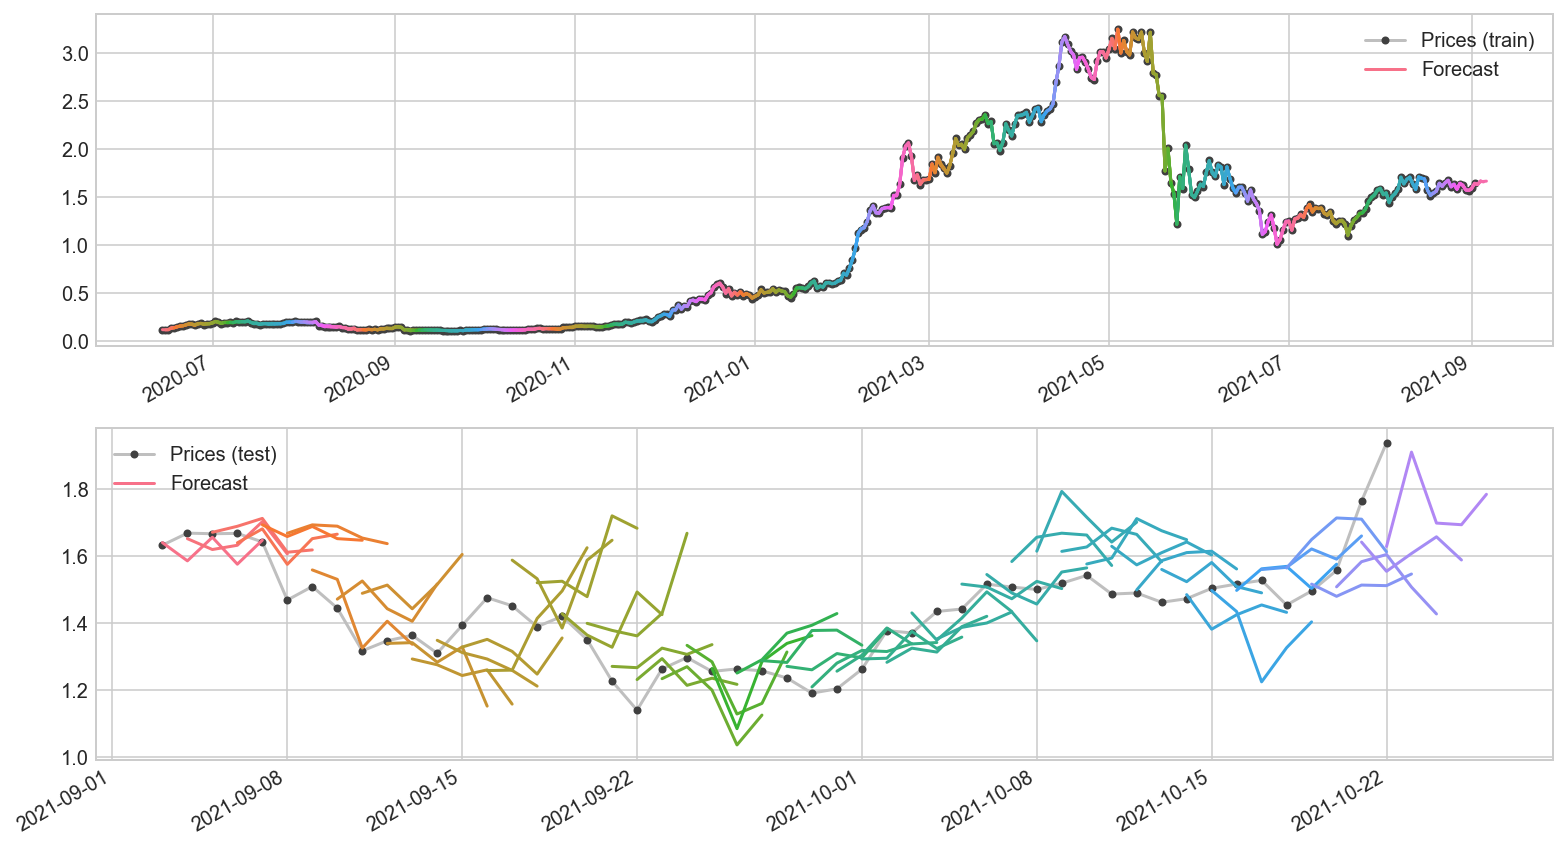

In [12]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = df.prices[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Prices (train)', 'Forecast'])

ax2 = df.prices[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Prices (test)', 'Forecast'])

XGB is performing here much worse than the linear model. We may tune the model a bit.

In [14]:
# Testing DirRec
from sklearn.multioutput import RegressorChain

model = RegressorChain(XGBRegressor(n_jobs=1))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [15]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 0.02
Test RMSE: 0.19


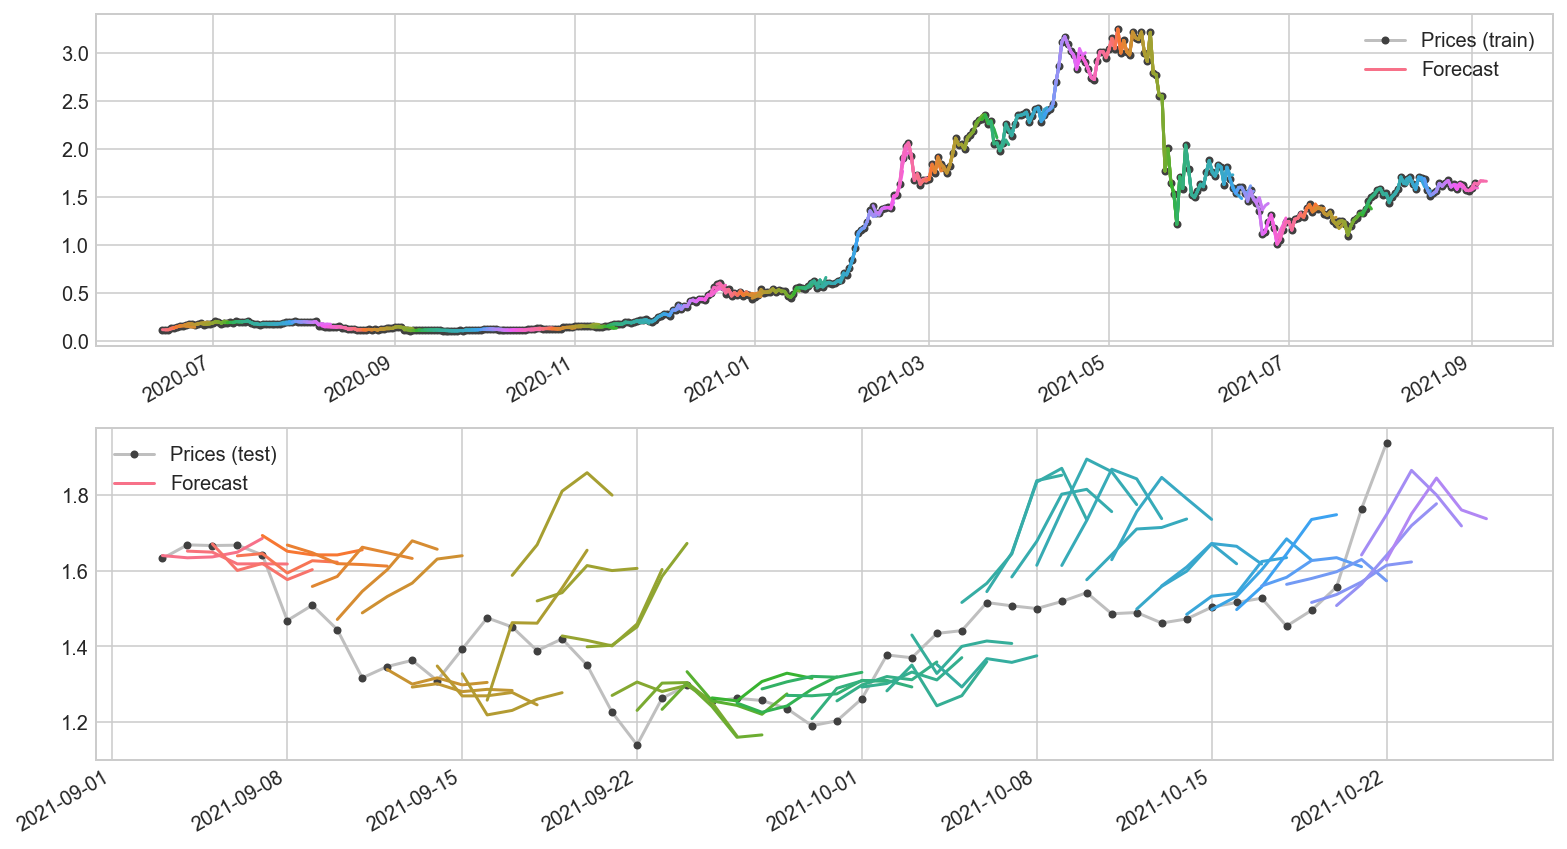

In [16]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = df.prices[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Prices (train)', 'Forecast'])

ax2 = df.prices[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Prices (test)', 'Forecast'])

We're not getting better here ;).

# More Sources
https://www.kaggle.com/learn/time-series
https://www.kaggle.com/c/favorita-grocery-sales-forecasting
https://www.kaggle.com/c/rossmann-store-sales/overview
https://www.kaggle.com/c/web-traffic-time-series-forecasting/overview
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting
https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather
https://www.kaggle.com/c/m5-forecasting-accuracy
https://www.researchgate.net/publication/339362837_Learnings_from_Kaggle's_Forecasting_Competitions
